In [1]:
import torch
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from model import VGG

In [ ]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)
    
# initialize the model
model = VGG()

# set the evaluation mode
model.eval()

In [3]:
# get the image from the dataloader
img, _ = next(iter(dataloader))
img.size()

torch.Size([1, 3, 224, 224])

In [7]:
# get the most likely prediction of the model
pred = model(img)


In [9]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 386].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

In [10]:
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

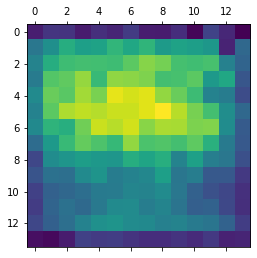

In [11]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [24]:
import cv2
img = cv2.imread('data/o/1.png')
heatmap = np.array(heatmap)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [21]:
heatmap.size()

torch.Size([14, 14])

In [23]:
cv2.resize(np.array(heatmap), (1920, 1440))

array([[0.08477114, 0.08477114, 0.08477114, ..., 0.        , 0.        ,
        0.        ],
       [0.08477114, 0.08477114, 0.08477114, ..., 0.        , 0.        ,
        0.        ],
       [0.08477114, 0.08477114, 0.08477114, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0407134 , 0.0407134 , 0.0407134 , ..., 0.10287732, 0.10287732,
        0.10287732],
       [0.0407134 , 0.0407134 , 0.0407134 , ..., 0.10287732, 0.10287732,
        0.10287732],
       [0.0407134 , 0.0407134 , 0.0407134 , ..., 0.10287732, 0.10287732,
        0.10287732]], dtype=float32)

In [19]:
img = cv2.imread('data/o/1.png')
print(img.shape)

(1440, 1920, 3)
